# VOICE CLONING AND FAKE AUDIO DETECTION 

## PHASE 2 - SIGNAL PROCESSING AND DATASET CONSOLIDATION

### OBJECTIVE

- Consolidate the CommonVoice audio dataset as the ground truth along with TIMIT samples from the VCS, apply signal transformations, analyze waveforms and frequency variations and save the meta data for building FAD (Fake Audio Detection) model.

### METHODOLOGY

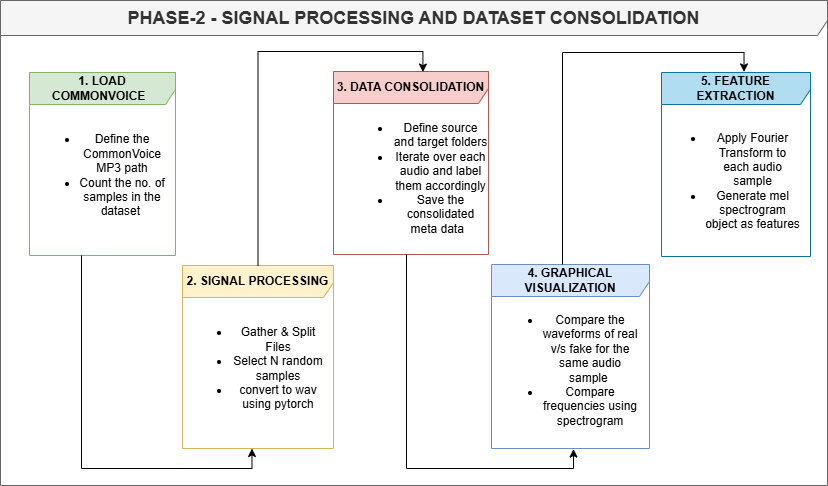
  

In [1]:
import torch, torchaudio, soundfile as sf, os, random
from tqdm import tqdm
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import os, glob
print('installed all dependencies...')


installed all dependencies...


## STEP - 1 : LOAD THE COMMONVOICE MP3 DATASET

In [2]:
# define the CommonVoice MP3 path
mp3_dir = "CommonVoice_audio_clips/en/clips"

# check how many total samples are in the CommonVoice Dataset
files = [f for f in os.listdir(mp3_dir) if f.endswith(".mp3")]
print("Example file:", files[0] if files else "No mp3 found")
print("Total mp3 files found:", len(files))

Example file: common_voice_en_41236242.mp3
Total mp3 files found: 27408


## STEP - 2 : SIGNAL PROCESSING COMMONVOICE AUDIO SAMPLES 

In [10]:
import random, os
import torchaudio, soundfile as sf, os, random
from tqdm import tqdm

src_dir = "CommonVoice_audio_clips/en/clips"
target_dir = "data/commonvoice/real"

os.makedirs(target_dir, exist_ok=True)

# -----------------------------
# 1. Gather & Split Files
# -----------------------------
all_mp3s = [f for f in os.listdir(src_dir) if f.endswith(".mp3")]
random.shuffle(all_mp3s)

# Adjust number of samples as needed
train_size = 5000
train_files = all_mp3s[:train_size]

print(f"🎧 Selected {len(train_files)} train MP3s")

# -----------------------------
# 2. Conversion Function
# -----------------------------
'''
convert_with_torchaudio() : a pytorch function to convert the mp3 commonvoice samples to wav samples
@params : src_dir - source directory where the mp3 are downloaded from the publicly available dataset,
          dest_dir - target directory where the wav files are to be saved,
          file_list - an array holding the list of files for iteration,
          target_sr - sampling rate at which the file processing is to be performed
@return: None
'''
def convert_with_torchaudio(src_dir, file_list, dest_dir, target_sr=16000):
    for fname in tqdm(file_list, desc=f"Converting {len(file_list)} files → {dest_dir}"):
        mp3_path = os.path.join(src_dir, fname)
        wav_path = os.path.join(dest_dir, fname.replace(".mp3", ".wav"))
        try:
            # Load MP3 → Tensor
            wav, sr = torchaudio.load(mp3_path)
            if sr != target_sr:
                wav = torchaudio.functional.resample(wav, sr, target_sr)
            # Convert to mono and normalize
            wav = wav.mean(dim=0, keepdim=True)
            wav = (wav / wav.abs().max()) * 0.95
            sf.write(wav_path, wav.squeeze().numpy(), target_sr, subtype="PCM_16")
        except Exception as e:
            print(f"⚠️ Skipping {fname}: {e}")

# -----------------------------
# 🚀 Convert Train & Test
# -----------------------------
# convert_with_torchaudio(src_dir, train_files, target_dir)
# convert_with_torchaudio(src_dir, test_files, test_dir)

print("✅ CommonVoice ground truth dataset ready!")

🎧 Selected 5000 train MP3s
✅ CommonVoice ground truth dataset ready!


## STEP - 3 : CONSOLIDATE DATASET FROM TIMIT AND COMMONVOICE

In [11]:
import os
from pathlib import Path

'''
count_wavs() : a function to count the number of files in each dataset and print the count
@params : path - the file where the no of files are to be counted
@return : None
'''
def count_wavs(path):
    return len([f for f in Path(path).rglob("*.wav")])

summary = {
    "CommonVoice Real": count_wavs("data/commonvoice/real"),
    "TIMIT Train Real": count_wavs("data/timit/train/real"),
    "TIMIT Train Fake": count_wavs("data/timit/train/fake"),
    "TIMIT Test Real": count_wavs("data/timit/test/real"),
    "TIMIT Test Fake": count_wavs("data/timit/test/fake"),
}

for k, v in summary.items():
    print(f"{k:25s}: {v:,} files")

print(f"\n✅ Total = {sum(summary.values()):,} audio samples")

CommonVoice Real         : 5,000 files
TIMIT Train Real         : 2,313 files
TIMIT Train Fake         : 2,310 files
TIMIT Test Real          : 843 files
TIMIT Test Fake          : 840 files

✅ Total = 11,306 audio samples


In [14]:
import os
import pandas as pd
from glob import glob

# Define your source folders
real_dirs = [
    "data/commonvoice/real",
    "data/timit/train/real",
    "data/timit/test/real",
]

fake_dirs = [
    "data/timit/train/fake",
    "data/timit/test/fake",
]

# Collect files
real_files = []
for d in real_dirs:
    real_files.extend(glob(os.path.join(d, "*.wav")))

fake_files = []
for d in fake_dirs:
    fake_files.extend(glob(os.path.join(d, "*.wav")))

# Create dataframe
df_fad = pd.DataFrame({
    "path": real_files + fake_files,
    "label": [0]*len(real_files) + [1]*len(fake_files)
})

# Shuffle rows
df_fad = df_fad.sample(frac=1, random_state=42).reset_index(drop=True)

# Normalize all paths to use forward slashes
df_fad["path"] = df_fad["path"].apply(lambda x: x.replace("\\", "/"))


print(f"✅ FAD dataset created: {len(df_fad)} total samples")
print(f"   Real (label=0): {len(real_files)} | Fake (label=1): {len(fake_files)}")

# Uncommented to save to CSV
# os.makedirs("data", exist_ok=True)
# df_fad.to_csv("data/fad_dataset.csv", index=False)

df_fad.head()

✅ FAD dataset created: 11306 total samples
   Real (label=0): 8156 | Fake (label=1): 3150


,path,label
0,data/timit/train/fake/206_4131.wav,1
1,data/timit/train/real/48_3195.wav,0
2,data/commonvoice/real/common_voice_en_41817087...,0
3,data/timit/train/fake/353_0741.wav,1
4,data/timit/train/fake/82_2778.wav,1


## STEP - 4 : GRAPHICAL VISUALIZATION OF OF FAKE AND REAL SAMPES

🎧 Comparing real vs fake for utterance: 296_0945
  Real: data\timit\train\real\296_0945.wav
  Fake: data\timit\train\fake\296_0945.wav


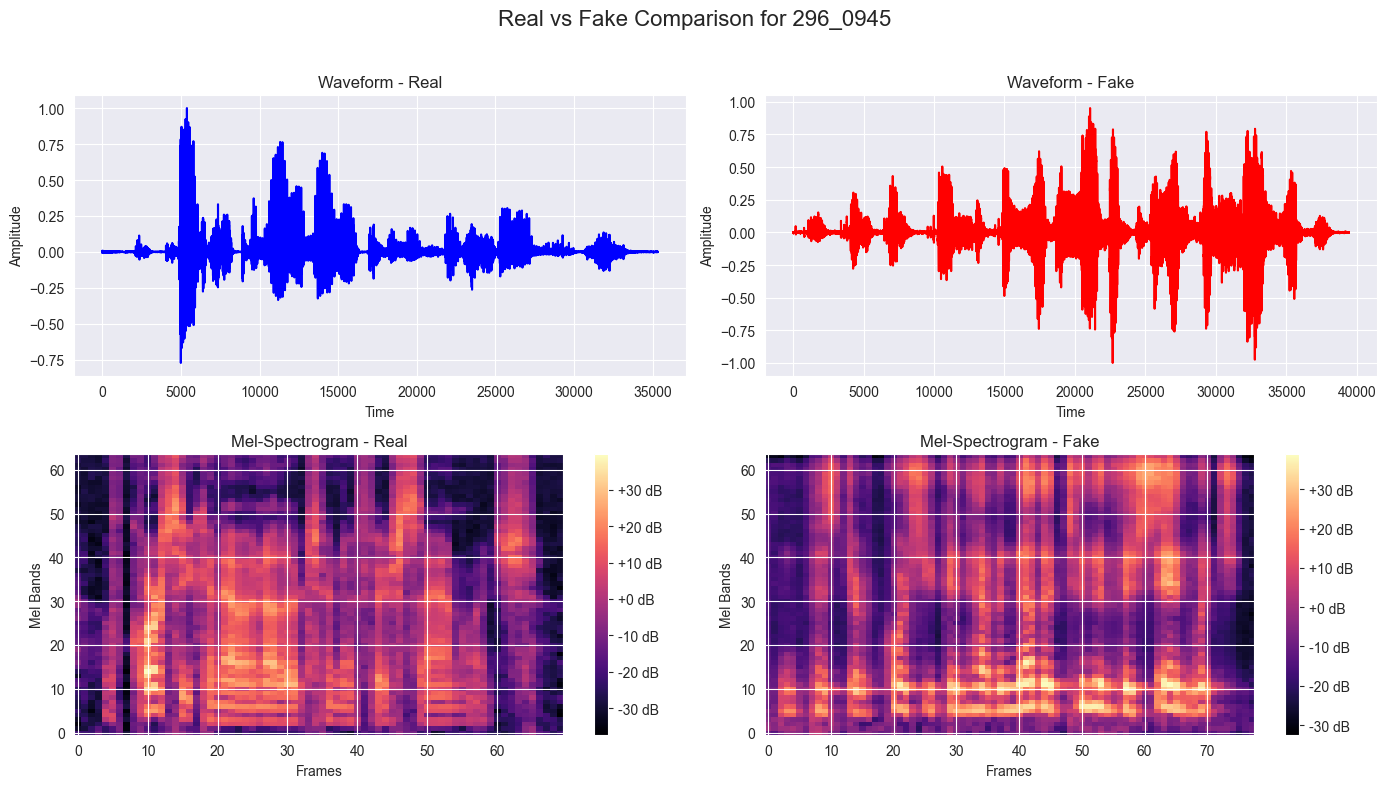

🎧 Real sample:


🎧 Fake sample:


In [17]:
import torchaudio, matplotlib.pyplot as plt, os
from pathlib import Path
from IPython.display import Audio
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')

# Pick one sample ID that exists in both real & fake
real_dir = Path("data/timit/train/real")
fake_dir = Path("data/timit/train/fake")

# Find all common base filenames (without extension)
real_files = {f.stem for f in real_dir.glob("*.wav")}
fake_files = {f.stem for f in fake_dir.glob("*.wav")}
common_files = list(real_files & fake_files)

if not common_files:
    raise ValueError("No matching real/fake file pairs found!")

sample_id = common_files[100]  # pick the first match
real_path = real_dir / f"{sample_id}.wav"
fake_path = fake_dir / f"{sample_id}.wav"

print(f"🎧 Comparing real vs fake for utterance: {sample_id}")
print(f"  Real: {real_path}")
print(f"  Fake: {fake_path}")

# Load both
wav_real, sr_real = torchaudio.load(str(real_path))
wav_fake, sr_fake = torchaudio.load(str(fake_path))
target_sr = 16000
if sr_real != target_sr:
    wav_real = torchaudio.functional.resample(wav_real, sr_real, target_sr)
if sr_fake != target_sr:
    wav_fake = torchaudio.functional.resample(wav_fake, sr_fake, target_sr)

# Normalize
wav_real = wav_real / wav_real.abs().max()
wav_fake = wav_fake / wav_fake.abs().max()

# Create mel transform
mel = torchaudio.transforms.MelSpectrogram(sample_rate=target_sr, n_fft=1024, hop_length=512, n_mels=64)
to_db = torchaudio.transforms.AmplitudeToDB()

mel_real = to_db(mel(wav_real))
mel_fake = to_db(mel(wav_fake))

# --- Plotting ---
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
plt.suptitle(f"Real vs Fake Comparison for {sample_id}", fontsize=16)

# Waveforms
axs[0, 0].plot(wav_real.squeeze().numpy(), color='blue')
axs[0, 0].set_title("Waveform - Real")
axs[0, 1].plot(wav_fake.squeeze().numpy(), color='red')
axs[0, 1].set_title("Waveform - Fake")

for ax in axs[0]:
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")

# Mel-Spectrograms
im1 = axs[1, 0].imshow(mel_real[0].numpy(), origin='lower', aspect='auto', cmap='magma')
axs[1, 0].set_title("Mel-Spectrogram - Real")
im2 = axs[1, 1].imshow(mel_fake[0].numpy(), origin='lower', aspect='auto', cmap='magma')
axs[1, 1].set_title("Mel-Spectrogram - Fake")

for ax in axs[1]:
    ax.set_xlabel("Frames")
    ax.set_ylabel("Mel Bands")

fig.colorbar(im1, ax=axs[1, 0], format="%+2.0f dB")
fig.colorbar(im2, ax=axs[1, 1], format="%+2.0f dB")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Optionally play both
print("🎧 Real sample:")
display(Audio(wav_real.squeeze().numpy(), rate=target_sr))
print("🎧 Fake sample:")
display(Audio(wav_fake.squeeze().numpy(), rate=target_sr))

### OBSERVATIONS

| **Aspect** | **Real TIMIT Audio** | **Fake TIMIT Audio** |
|-------------|----------------|----------------|
| **Amplitude Pattern (Waveform)** | More natural amplitude variation with smoother transitions between speech segments. | Higher amplitude peaks and more uniform energy variations - evidence of external smoothening. |
| **Temporal Structure** | Clear silence gaps and distinct phoneme boundaries, typical of natural speech. | Less silence between segments; transitions appear more abrupt or evenly spaced. |
| **Spectrogram (Mel Bands)** | Richer harmonic structure and smoother formant transitions. | Slightly blurred or smeared harmonics, with less detailed formant definition. |
| **Overall Naturalness** | Appears authentic, with organic timing and spectral variation. | Sounds more synthetic - consistent energy and less variability in texture. |


🎧 CommonVoice real sample: common_voice_en_41731591.wav


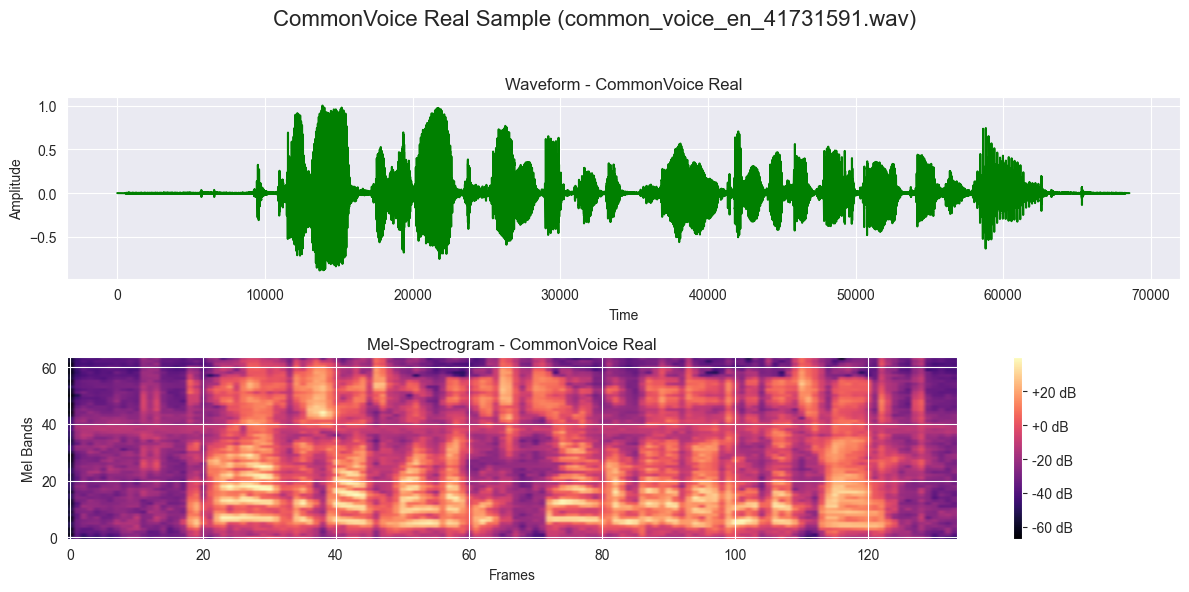

In [18]:
import torchaudio, matplotlib.pyplot as plt, random
from IPython.display import Audio

# Path to your CommonVoice real directory
cv_dir = "data/commonvoice/real"

# Pick a random CommonVoice real sample
cv_files = [f for f in os.listdir(cv_dir) if f.endswith(".wav")]
cv_sample = random.choice(cv_files)
cv_path = os.path.join(cv_dir, cv_sample)

print(f"🎧 CommonVoice real sample: {cv_sample}")

# Load and preprocess
wav_cv, sr_cv = torchaudio.load(cv_path)
target_sr = 16000
if sr_cv != target_sr:
    wav_cv = torchaudio.functional.resample(wav_cv, sr_cv, target_sr)
wav_cv = wav_cv / wav_cv.abs().max()

# Mel transform (same as before)
mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=target_sr,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)
to_db = torchaudio.transforms.AmplitudeToDB()

mel_cv = to_db(mel(wav_cv))

# --- Plot ---
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
plt.suptitle(f"CommonVoice Real Sample ({cv_sample})", fontsize=16)

# Waveform
axs[0].plot(wav_cv.squeeze().numpy(), color='green')
axs[0].set_title("Waveform - CommonVoice Real")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Amplitude")

# Mel-Spectrogram
im = axs[1].imshow(mel_cv[0].numpy(), origin='lower', aspect='auto', cmap='magma')
axs[1].set_title("Mel-Spectrogram - CommonVoice Real")
axs[1].set_xlabel("Frames")
axs[1].set_ylabel("Mel Bands")
fig.colorbar(im, ax=axs[1], format="%+2.0f dB")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Optional: listen
display(Audio(wav_cv.squeeze().numpy(), rate=target_sr))

## STEP - 5 : FEATURE EXTRACTION WITH MEL-SPECTROGRAM

In [19]:
import os, numpy as np, pandas as pd, torchaudio
from pathlib import Path
from tqdm import tqdm

df = pd.read_csv("data/fad_dataset.csv")
df["path"] = df["path"].str.replace("\\", "/", regex=False)

mel_dir = Path("data/mels"); mel_dir.mkdir(parents=True, exist_ok=True)

mel_tx = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000, n_fft=1024, hop_length=512, n_mels=64
)
to_db = torchaudio.transforms.AmplitudeToDB()

paths, labels = [], []
for i, row in tqdm(df.iterrows(), total=len(df), desc="Precomputing mels"):
    try:
        wav, sr = torchaudio.load(row.path)
        if sr != 16000:
            wav = torchaudio.functional.resample(wav, sr, 16000)
        wav = wav.mean(dim=0, keepdim=True)                 # mono
        mel = to_db(mel_tx(wav)).numpy()                   # (1, 64, T)
        npy = mel_dir / f"{i:06d}.npy"
        np.save(npy, mel)
        paths.append(str(npy)); labels.append(int(row.label))
    except Exception as e:
        print(f"skip {row.path}: {e}")

pd.DataFrame({"path": paths, "label": labels}).to_csv("data/fad_mel_dataset.csv", index=False)
print("✅ saved:", len(paths), "mel files → data/mels/")

Precomputing mels: 100%|█████████████████████████████████████████████████████████| 11306/11306 [03:56<00:00, 47.74it/s]

✅ saved: 11306 mel files → data/mels/


In [20]:
# view the saved dataset 
df_mel_test = pd.read_csv('data/fad_mel_dataset.csv')
df_mel_test.head()

,path,label
0,data\mels\000000.npy,1
1,data\mels\000001.npy,0
2,data\mels\000002.npy,0
3,data\mels\000003.npy,1
4,data\mels\000004.npy,1


In [21]:
df_mel_test.label.value_counts()

label
0    8156
1    3150
Name: count, dtype: int64